In [2]:
import numpy as np
import cv2
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# 1. Load Accelerometer Data 
##  Dataset is a vector of 151 accelerometer values for each axis. 

In [3]:
data =np.load("dataset/two_classes_data.npy")

In [4]:
x_axis_data = data[:,:151]

In [5]:
x_axis_data.shape

(11771, 151)

In [6]:
y_axis_data = data[:,151:302]

In [7]:
y_axis_data.shape

(11771, 151)

In [8]:
z_axis_data = data[:,302:453]

In [9]:
z_axis_data.shape

(11771, 151)

## Data labels contain 3 columns, we use only first column to classify human activities

In [45]:
Labels =np.load("dataset/two_classes_labels.npy")

In [46]:
Labels

array([[ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       ...,
       [ 2, 30,  6],
       [ 2, 30,  6],
       [ 2, 30,  6]], dtype=uint8)

In [47]:
hum_act_labels = Labels[:,0]

In [48]:
hum_act_labels

array([1, 1, 1, ..., 2, 2, 2], dtype=uint8)

## Class names

In [18]:
names =np.load("dataset/acc_names.npy",allow_pickle=True)

In [19]:
names

array([[array(['Standing up from sitting'], dtype='<U24'),
        array(['Standing up from laying'], dtype='<U23'),
        array(['Walking'], dtype='<U7'), array(['Running'], dtype='<U7'),
        array(['Going upstairs'], dtype='<U14'),
        array(['Jumping'], dtype='<U7'),
        array(['Going downstairs'], dtype='<U16'),
        array(['Lying down from standing'], dtype='<U24'),
        array(['Sitting down'], dtype='<U12'),
        array(['Generic falling forward'], dtype='<U23'),
        array(['Falling rightward'], dtype='<U17'),
        array(['Generic falling backward'], dtype='<U24'),
        array(['Hitting an obstacle in the fall'], dtype='<U31'),
        array(['Falling with protection strategies'], dtype='<U34'),
        array(['Falling backward-sitting-chair'], dtype='<U30'),
        array(['Syncope'], dtype='<U7'),
        array(['Falling leftward'], dtype='<U16')],
       [array(['StandingUpFS'], dtype='<U12'),
        array(['StandingUpFL'], dtype='<U12'),
      

In [20]:
names.shape

(2, 17)

In [21]:
class_names = names[0:1,:]

In [22]:
class_names

array([[array(['Standing up from sitting'], dtype='<U24'),
        array(['Standing up from laying'], dtype='<U23'),
        array(['Walking'], dtype='<U7'), array(['Running'], dtype='<U7'),
        array(['Going upstairs'], dtype='<U14'),
        array(['Jumping'], dtype='<U7'),
        array(['Going downstairs'], dtype='<U16'),
        array(['Lying down from standing'], dtype='<U24'),
        array(['Sitting down'], dtype='<U12'),
        array(['Generic falling forward'], dtype='<U23'),
        array(['Falling rightward'], dtype='<U17'),
        array(['Generic falling backward'], dtype='<U24'),
        array(['Hitting an obstacle in the fall'], dtype='<U31'),
        array(['Falling with protection strategies'], dtype='<U34'),
        array(['Falling backward-sitting-chair'], dtype='<U30'),
        array(['Syncope'], dtype='<U7'),
        array(['Falling leftward'], dtype='<U16')]], dtype=object)

In [23]:
class_names.shape

(1, 17)

# VLAD Feature Encoding Technique

In [24]:
def sliding_window(data):
    window_size = 40
    stride = 10
    return np.lib.stride_tricks.sliding_window_view(data,window_size)[::stride,:]

In [25]:
def GMM(data):
    gmm = GaussianMixture(n_components=12, covariance_type='spherical').fit(data)
    return gmm.means_

In [26]:
def find_NearestNeighbour(localdes,neighborhood):
    """
    Finds the nearest neighborhood of a vector.
    Args:
        point (float array): The initial point.
        neighborhood (numpy float matrix): The points that are around the initial point.
    Returns:
        float array: The point that is the nearest neighbor of the initial point.
        integer: Index of the nearest neighbor inside the neighborhood list
    """
    min_distance = float('inf')
    NearestNeighbour = neighborhood[0]
    NearestN_index = 0
    for i in range(len(neighborhood)):
        neighbor = neighborhood[i]
        distance = cv2.norm(localdes - neighbor)
        if distance < min_distance:
            min_distance = distance
            NearestNeighbour = neighbor
            NearestN_index = i 
    return NearestNeighbour, NearestN_index          

In [27]:
def vlad (localdescriptors, centers):
    """
    Calculate the Vector of Locally Aggregated Descriptors (VLAD) which is a global descriptor from a group of
    descriptors and centers that are codewords of a codebook, obtained for example with K-Means.
    Args:
        descriptors (numpy float matrix): The local descriptors.
        centers (numpy float matrix): The centers are points representatives of the classes.
    Returns:
        numpy float array: The VLAD vector.
    """    
        
    dimensions = len(localdescriptors[0])
    vlad_vector = np.zeros((len(centers), dimensions), dtype=np.float32)
    for localdescriptors in localdescriptors:
        nearest_center, center_index = find_NearestNeighbour(localdescriptors,centers)
        for i in range(dimensions):
            vlad_vector[center_index][i] += (localdescriptors[i] - nearest_center[i])
    # L2 Normalization            
    vlad_vector = cv2.normalize(vlad_vector,vlad_vector)
    vlad_vector = vlad_vector.flatten()
    return vlad_vector   
        

In [28]:
    #sliding window in every row
slide_vec = sliding_window(x_axis_data[0])
    #GMM in slide_vec shape 12X30
slide_vec.shape

(12, 40)

## X_axis 

In [29]:
xfeaturevector = np.zeros((11771,480))
for i in range(x_axis_data.shape[0]):
    #sliding window in every row
    slide_vec = sliding_window(x_axis_data[i])
    #GMM in slide_vec shape 12X30
    codebook = GMM(slide_vec)
    #vlad implement retirn 480 dimensions
    v = vlad(slide_vec,codebook) 
    xfeaturevector[i] = v


## K*D dimensions, K=12,D=40, and K*D=480

In [30]:
xfeaturevector.shape

(11771, 480)

In [31]:
xfeaturevector

array([[ 0.07585517,  0.07186279,  0.07186279, ..., -0.00174667,
         0.00112286,  0.00212095],
       [ 0.00451155,  0.00620338,  0.0090231 , ...,  0.00310169,
         0.00281972,  0.00239676],
       [-0.01253129, -0.01190472, -0.01065159, ...,  0.0087719 ,
         0.01002503,  0.01002503],
       ...,
       [ 0.00633615, -0.00043201,  0.00345608, ...,  0.02534461,
         0.02534461,  0.02764867],
       [ 0.01601057,  0.01486696,  0.01715419, ...,  0.02287225,
         0.02287225,  0.02287225],
       [ 0.0434523 ,  0.04573926,  0.04573926, ...,  0.02286963,
         0.02286963,  0.02286963]])

## Y_axis 

In [32]:
yfeaturevector = np.zeros((11771,480))
for i in range(y_axis_data.shape[0]):
    #sliding window in every row
    slide_vec = sliding_window(y_axis_data[i])
    #GMM in slide_vec shape 12X30
    codebook = GMM(slide_vec)
    #vlad implement retirn 480 dimensions
    v = vlad(slide_vec,codebook) 
    yfeaturevector[i] = v


## K*D dimensions, K=12,D=40, and K*D=480

In [33]:
yfeaturevector.shape

(11771, 480)

In [34]:
yfeaturevector

array([[ 0.04554765,  0.04858416,  0.04858416, ...,  0.05162067,
         0.05162067,  0.05162067],
       [ 0.04698347,  0.04698347,  0.04404701, ...,  0.04991994,
         0.04991994,  0.04991994],
       [ 0.0049793 ,  0.00248965,  0.00040696, ...,  0.0428986 ,
         0.0428986 ,  0.03983442],
       ...,
       [ 0.06251979,  0.05683617,  0.05683617, ..., -0.01349859,
        -0.01349859, -0.01420904],
       [ 0.06410372,  0.06410372,  0.06410372, ..., -0.01522463,
        -0.01522463, -0.01522463],
       [ 0.07348905,  0.07348905,  0.07348905, ..., -0.01586695,
        -0.01503185, -0.01586695]])

## Z_axis 

In [35]:
zfeaturevector =np.zeros((11771,480))
for i in range(z_axis_data.shape[0]):
    #sliding window in every row
    slide_vec = sliding_window(z_axis_data[i])
    #GMM in slide_vec shape 12X30
    codebook = GMM(slide_vec)
    #vlad implement retirn 480 dimensions
    v = vlad(slide_vec,codebook) 
    zfeaturevector[i] = v


## K*D dimensions, K=12,D=40, and K*D=480

In [36]:
zfeaturevector.shape

(11771, 480)

In [37]:
zfeaturevector

array([[-0.00909112, -0.00991759, -0.00661173, ..., -0.05619968,
        -0.05289382, -0.05289382],
       [-0.01006252, -0.00696636, -0.00928848, ..., -0.0464424 ,
        -0.0464424 , -0.0464424 ],
       [-0.04878874, -0.04878874, -0.04591881, ..., -0.05165866,
        -0.04878874, -0.04878874],
       ...,
       [-0.00127247,  0.08652793,  0.12215707, ...,  0.005408  ,
         0.00604423,  0.00413553],
       [ 0.00576678,  0.00461342,  0.00576678, ...,  0.0051901 ,
         0.00403675,  0.00374841],
       [ 0.00475918,  0.00531908,  0.00447923, ...,  0.05375071,
         0.05375071,  0.05375071]])

# CONCATENATE AXIS

In [38]:
final_feature_vector = np.concatenate((xfeaturevector,yfeaturevector,zfeaturevector),axis=1)
final_feature_vector.shape

(11771, 1440)

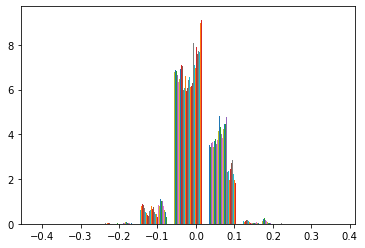

In [39]:
pyplot.hist(final_feature_vector,bins = 9,density = True)
pyplot.show()

# Data splitting

In [49]:
train_data, test_data, train_labels, test_labels = train_test_split(final_feature_vector, hum_act_labels, 
                                                    train_size=0.8,
                                                    test_size=0.2,
                                                    random_state=0)
print("Labels for training and testing data")
print(len(train_data))
print(len(test_data))

Labels for training and testing data
9416
2355


In [50]:
print(len(train_labels))
print(len(test_labels))

9416
2355


In [51]:
labels = np.unique(train_labels)
print(labels) 

[1 2]


In [52]:
model = SVC(kernel='linear')

In [53]:
model.fit(train_data, train_labels)

SVC(kernel='linear')

In [54]:
predictionstrain = model.predict(train_data)
print(predictionstrain)
print(train_labels)

[1 1 2 ... 1 1 1]
[1 2 2 ... 2 2 1]


In [55]:
percentage_train = model.score(train_data, train_labels)

In [56]:
predictionstest = model.predict(test_data)
print(predictionstest)
print(test_labels)

[2 2 1 ... 1 1 1]
[2 2 1 ... 1 2 1]


In [57]:
percentage_test = model.score(test_data, test_labels)

In [58]:
from sklearn.metrics import confusion_matrix
res = confusion_matrix(test_labels, predictionstest)
print("Confusion Matrix")
print(res)
print(f"Test Set: {len(test_data)}")
print(f"Training Accuracy = {percentage_train*100} %")
print(f"Testing Accuracy = {percentage_test*100} %")

Confusion Matrix
[[1450   39]
 [ 403  463]]
Test Set: 2355
Training Accuracy = 82.8377230246389 %
Testing Accuracy = 81.23142250530786 %
